Authored by *Tyler Norlund* and *Edwin Ramirez*

# Machine Learning HW3
**Clustering and Radial Basis Functions**

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from math import exp

## Problem 1

In this problem you will use the data file “kMeansData.csv” ($x_1$ and $x_2$ denote the input features) to create 3 clusters using unsupervised Lloyd’s k-means algorithm.

The training should only stop if the difference between the cluster center locations in two consecutive iterations is less than 0.001 or if the number of iterations has reached 1000. For the initial selection of cluster locations choose 3 points from the data set randomly.

After convergence, report the final cluster centers. Plot the 3 clusters in different colors with cluster centers clearly marked on the plot.

*Answer*

In order to implement Lloyd's k-means algorithm, we need to:
1. Generate the random centers
2. 

In [2]:
df = pd.read_csv('kMeansData.csv')
df['cls'] = np.nan

In [3]:
num_centers = 3
centers = []
for ii in range(num_centers):
    centers.append((
        random.uniform(df.x1.min(),df.x1.max()), 
        random.uniform(df.x2.min(),df.x2.max())))
centers

[(3.1353892699399006, 2.187140917760029),
 (1.2600102085875124, 1.0559923630893804),
 (4.474138055736094, 0.26474706675315235)]

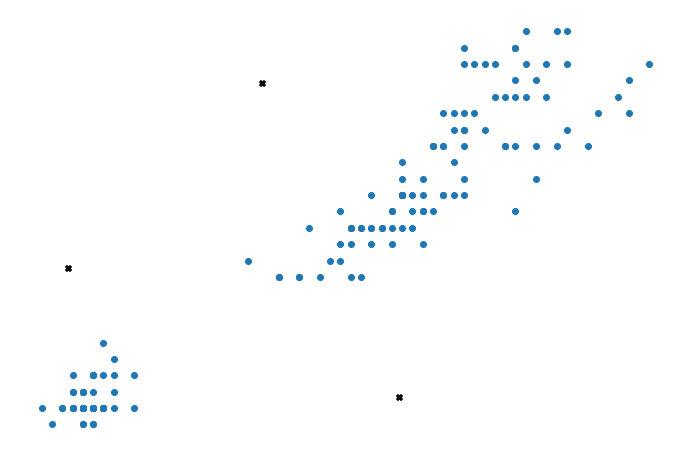

In [4]:
def plot_clusters(classes = False):
    fig, ax = plt.subplots(figsize = (12.0, 8.0))
    if classes:
        for ii in range(num_centers):
            ax.scatter(df[df['cls'] == ii].x1, df[df['cls'] == ii].x2)
    else:
        ax.scatter(df.x1, df.x2)
    [ax.scatter(center[0], center[1], marker='X', c='k') for center in centers]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(bottom=False, left=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.show()
plot_clusters()

So we can calculate the Euclidean distance between each point in order to classify each point.

$$\sqrt{
    (x_{1} - \texttt{center}_1)^{2} + 
    (x_{2} - \texttt{center}_2)^{2}
} $$

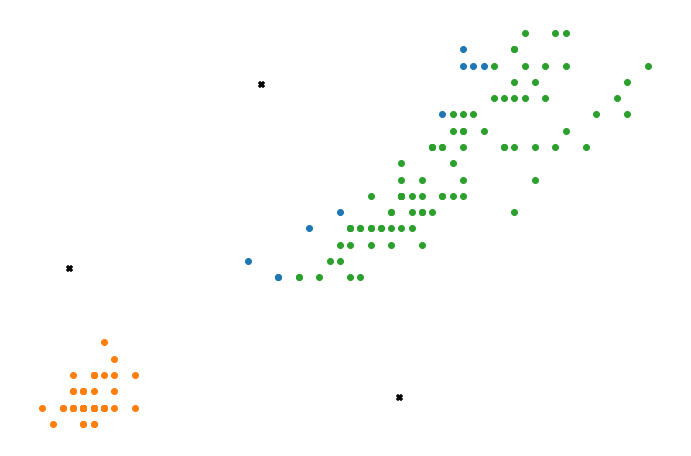

In [5]:
def assign_classes():
    for index, row in df.iterrows():
        val, idx = min((val, idx) for (idx, val) in enumerate(
            [((row.x1 - center[0])**2 + (row.x2 - center[1])**2)**0.5 for center in centers]))
        df.iloc[index]['cls'] = idx
assign_classes()
plot_clusters(classes=True)

Look at that! We were able to classify each point with a certain class. We can now update the centers to be in the centroid of each class. The assignment requires us to update the centers only if the delta is less than 0.001. The process will be:
1. Update the centers
2. Calculate the delta
3. Compare the previous two deltas
4. Repeat if the conditions are not meet

In [6]:
def get_delta():
    temp = []
    [temp.append((df[df['cls'] == float(ii)].x1.mean(), df[df['cls'] == float(ii)].x2.mean())) for ii in range(num_centers)]
    delta = []
    for ii in range(num_centers):
        delta.append((
            temp[ii][0] - centers[ii][0],
            temp[ii][1] - centers[ii][1]
        ))
    return delta

In [7]:
def compare_centers(deltas):
    temp = []
    count = 0
    for ii in range(1,3):
        for jj in range(len(deltas[ii])):
            temp.append((
                abs(deltas[ii][jj][0]-deltas[ii-1][jj][0]), 
                abs(deltas[ii][jj][1]-deltas[ii-1][jj][1])))
    for ii in temp:
        if(ii[0] < 0.01 and ii[1] < 0.01):
            count += 1
    return count == (num_centers - 1) * 3

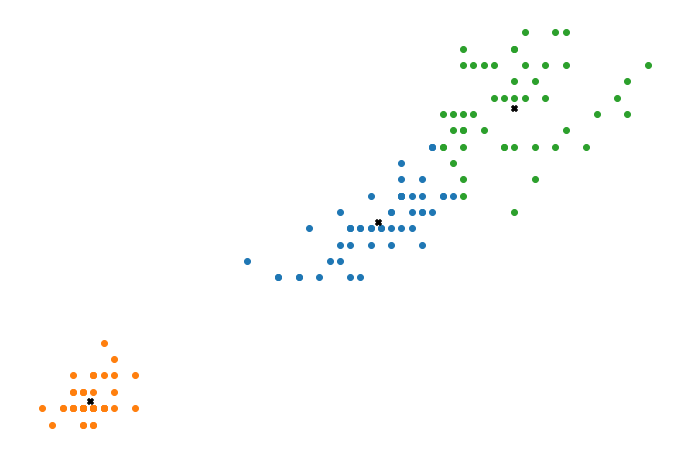

In [8]:
deltas = []
for ii in range(1000):
    centers = [(df[df['cls'] == float(ii)].x1.mean(), df[df['cls'] == float(ii)].x2.mean()) for ii in range(num_centers)]
    assign_classes()
    deltas.append(get_delta())
    if ii > 2:
        if compare_centers(deltas):
            break
        deltas.pop(0)
plot_clusters(classes=True)

## Problem 2

In this problem you will use the data file “rbfClassification.csv” to create an RBF classification model. $x_1$ and $x_2$ denote the input features and cls denotes the target class of the corresponding data points.

### 1

Use k-means clustering to determine the location of 2 cluster centers that you will use in your RBF model. Report the coordinate of the cluster centers.

*Answer*

In [9]:
df = pd.read_csv('rbfClassification.csv')
num_centers = 2
y = df.cls
df['cls'] = np.nan
centers = []
for ii in range(num_centers):
    centers.append((
        random.uniform(df.x1.min(),df.x1.max()), 
        random.uniform(df.x2.min(),df.x2.max())))
centers

[(1.913545044018484, 1.3957604858011394),
 (0.8259401511929014, -1.1516813957462633)]

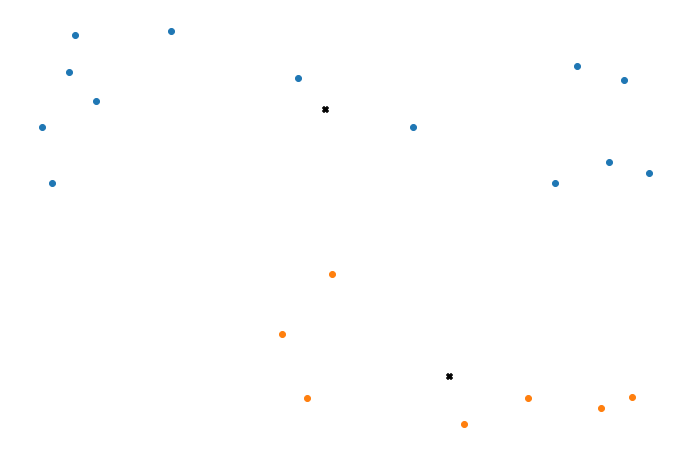

[(-0.33773905807692306, 1.844177636), (0.7932723952857144, -1.991931260714286)]

In [10]:
assign_classes()
deltas = []
for ii in range(1000):
    centers = [(df[df['cls'] == float(ii)].x1.mean(), df[df['cls'] == float(ii)].x2.mean()) for ii in range(num_centers)]
    assign_classes()
    deltas.append(get_delta())
    if ii > 2:
        if compare_centers(deltas):
            break
        deltas.pop(0)
plot_clusters(True)
centers

### 2

Train an RBF model using $\gamma = 0.5$. Report the correct classification rate of your model.

*Answer*

So! In order to solve for the RBF, we must define some variables. Let $\mu$ be the centers we found previously and $\gamma=0.5$. We can use the following estimation.

$$
\begin{bmatrix}
1 & e^{\gamma |X_{1} - \mu_{1} |^{2} } & e^{\gamma |X_{1} - \mu_{2} |^{2} } \\
1 & e^{\gamma |X_{2} - \mu_{1} |^{2} } & e^{\gamma |X_{2} - \mu_{2} |^{2} } \\
\vdots & \vdots & \vdots \\
1 & e^{\gamma |X_{N} - \mu_{1} |^{2} } & e^{\gamma |X_{N} - \mu_{2} |^{2} } \\
\end{bmatrix}
\begin{bmatrix}
w_{0} \\
w_{1} \\
w_{2}
\end{bmatrix}
\approx
\begin{bmatrix}
y_{0} \\
y_{1} \\
\vdots \\
y_{N}
\end{bmatrix}
$$

To save space, we can rewrite the equation as:

$$
\Phi w = y \text{.}
$$

Now we can solve for $w$ using linear regression:

$$
w = (\Phi^{T}\Phi)^{-1}\Phi^{T} y \text{.}
$$

In [11]:
gamma = 0.5
mu_1 = centers[0]
mu_2 = centers[1]
phi = []

for index, row in df.iterrows():
    phi.append([
        1,
        exp(-gamma * (((row.x1 - mu_1[0])**2 + (row.x2 - mu_1[1])**2)**0.5)**2),
        exp(-gamma * (((row.x1 - mu_2[0])**2 + (row.x2 - mu_2[1])**2)**0.5)**2)
    ])
phi = np.matrix(phi)
w = np.dot(np.dot(np.linalg.inv(np.dot(phi.T,phi)), phi.T), y).ravel().tolist()[0]
w

[0.49498036420517405, 0.1803730070243418, -0.7772475053739747]

Alright! After solving for $w$, we can classify the points. We have 2 centers, $\mu$, and 3 weights, $w$. We can use $h(x)$ to classify each point. We must remember that the linear regression used a column of $1$'s, and we will substitute $1$ in the summation. 

$$
h(x) = \sum_{k=1}^{K} w_{k} e^{-\gamma |x - \mu_{k} |^{2}}
$$

After computing $h(x)$, we can look at the graph and see that some $h$ values are greater than 0.5. The ones greater than 0.5 will be classified as class 1, while the ones less than 0.5 are classified as class 0.

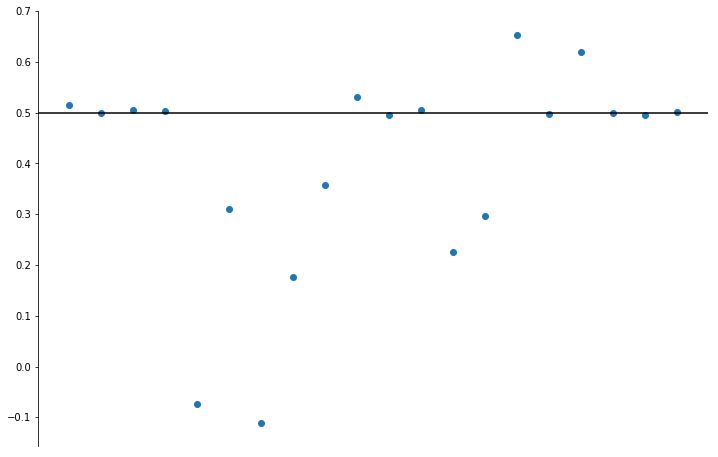

In [12]:
h = []
for index, row in df.iterrows():
    h.append(w[0] * 1 + \
        w[1] * exp(-gamma * (((row.x1 - mu_1[0])**2 + (row.x2 - mu_1[1])**2)**0.5)**2) + \
        w[2] * exp(-gamma * (((row.x1 - mu_2[0])**2 + (row.x2 - mu_2[1])**2)**0.5)**2))
fig, ax = plt.subplots(figsize = (12.0, 8.0))
ax.scatter(range(20), h)
ax.axhline(y=0.5, color='k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False)
ax.set_xticklabels([])
plt.show()

With the predictions out of the way, we can compare the predictions with the given classes. The following plot shows both the predictions and the given classifications. The smaller points being the given classification and the larger points being the predicted class.

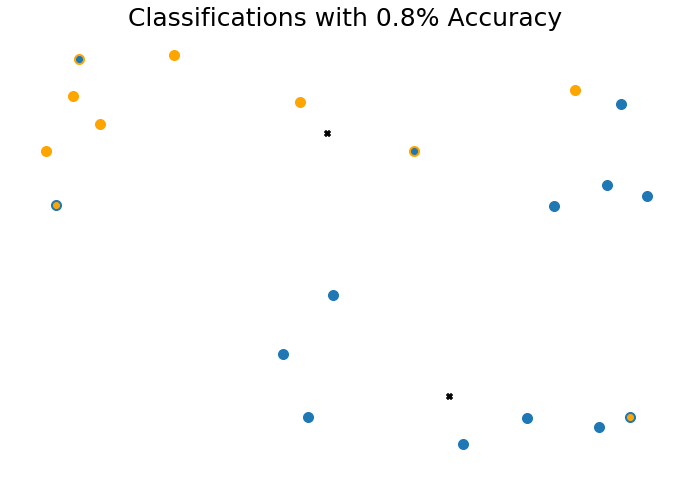

In [13]:
clas_rate = sum(y == [1 if val > 0.5 else 0 for val in h])/df.shape[0]
df['pred'] = [1.0 if val > 0.5 else 0.0 for val in h]
df['cls'] = y
fig, ax = plt.subplots(figsize = (12.0, 8.0))
ax.scatter(df[df['pred'] == 0].x1, df[df['pred'] == 0].x2, c=u'#1f77b4', s=100, zorder=0)
ax.scatter(df[df['pred'] == 1].x1, df[df['pred'] == 1].x2, c='orange', s=100, zorder=0)
ax.scatter(df[df['cls'] == 0].x1, df[df['cls'] == 0].x2, c=u'#1f77b4', zorder=1)
ax.scatter(df[df['cls'] == 1].x1, df[df['cls'] == 1].x2, c='orange', zorder=1)
plt.title(f'Classifications with {clas_rate}% Accuracy', fontsize=25)
[ax.scatter(center[0], center[1], marker='X', c='k', zorder=2) for center in centers]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

## Problem 3

The “stuFile.csv” is a list of students’ features at an academic institution that is considering starting a new program. The features include average yearly packaged financial aid, the number of years that the financial aid is awarded for, gender, marital status, marketing code, previous education, admission representative code, program code, citizenship code, ethnicity code, veteran code, and cancel flag code. Some of the students listed in the file cancelled their enrollment after meeting with Financial Aid. These students can be identified by the value of 1 in the cancel flag field.

This institution is considering starting a new program after researching the cannibalization rates, navigating regulatory requirements, and determining the potential market. There is an opportunity to market this program to students who cancelled before starting their originally intended program. The presump- tion is that the shorter duration and lower tuition rate of this program may be attractive to some students who cancelled.
Your task is to look into the data and provide some insight into who “might” enroll from this population using the clustering schemes discussed in class.

### 1

Use Value Metric Difference (VDM) to find and report the distance between the different levels of all categorical variables.

*Answer*

In [66]:
df = pd.read_csv(
    filepath_or_buffer='stuFile.csv',
    index_col=0)
[df.iloc[:,i].apply(type).value_counts() for i in range(df.shape[1])]

[<class 'int'>    2260
 Name: StuNum, dtype: int64, <class 'float'>    2260
 Name: avgYearPack, dtype: int64, <class 'int'>    2260
 Name: numYearAward, dtype: int64, <class 'str'>    2260
 Name: SexCode, dtype: int64, <class 'str'>    2260
 Name: MaritalCode, dtype: int64, <class 'str'>    2260
 Name: LeadCategoryCode, dtype: int64, <class 'str'>    2260
 Name: PrevEdCode, dtype: int64, <class 'int'>    2260
 Name: AdmRepName, dtype: int64, <class 'int'>    2260
 Name: ProgramCode, dtype: int64, <class 'str'>    2260
 Name: CitizenCode, dtype: int64, <class 'int'>    2260
 Name: IsHispanic, dtype: int64, <class 'int'>    2260
 Name: DDVeteran, dtype: int64, <class 'int'>    2260
 Name: cancelFlag.x, dtype: int64]

This dataset uses categorical variables for `numYearAward`, `SexCode`, `MaritalCode`, `LeadCategoryCode`, `PrevEdCode`, `AdmRepName`, `ProgramCode`, `CitizenCode`, `IsHispanic`, and `IsHispanic`. We will need to find the categorical probability of each of these parameters. 

In [67]:
params = ['numYearAward', 'SexCode', 'MaritalCode', 'LeadCategoryCode', 
          'PrevEdCode', 'AdmRepName', 'ProgramCode', 'CitizenCode', 
          'IsHispanic', 'IsHispanic']
prob = {}
for param in params:
    temp_1 = {}
    temp_2 = {}
    df[param] = pd.factorize(df[param].astype('category'))[0]
    for val in list(df[param].unique()):
        temp_1[val] = df[(df[param] == val) & (df['cancelFlag.x'] == 0)].shape[0]/df.shape[0]
        temp_2[val] = df[(df[param] == val) & (df['cancelFlag.x'] == 1)].shape[0]/df.shape[0]
    prob[param] = {
        'not_cancel': temp_1,
        'cancel': temp_2}

numYearAward
SexCode
MaritalCode
LeadCategoryCode
PrevEdCode
AdmRepName
ProgramCode
CitizenCode
IsHispanic
IsHispanic


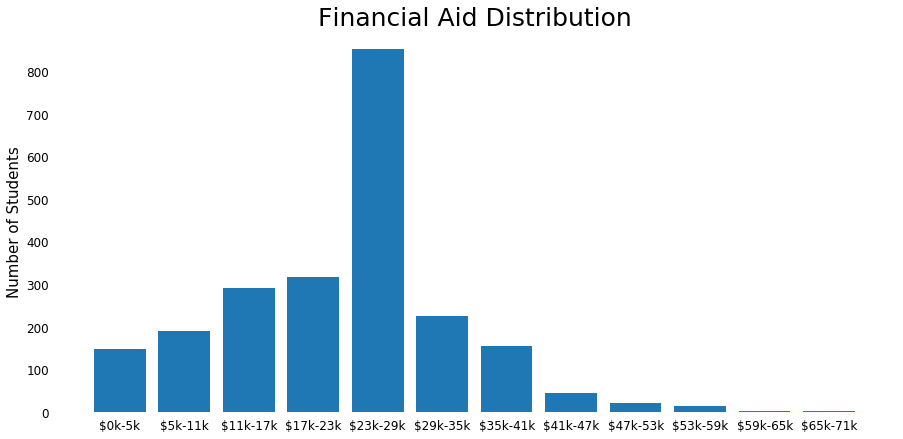

In [15]:
num_bar = 12
delta = int((df['avgYearPack'].max() - df['avgYearPack'].min())/num_bar)
bars = []
for ii in range(num_bar):
    bars.append(
        df[
            (df['avgYearPack'] >= ii*delta) & \
            (df['avgYearPack'] <= (ii+1)*delta)].shape[0])
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(list(range(num_bar)), bars)
plt.title('Financial Aid Distribution', fontsize=25)
plt.ylabel('Number of Students', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(bottom=False, left=False)
fig.canvas.draw()
plt.xticks(
    list(range(num_bar)),
    [f'${str(int(ii*delta/1000))}k-{str(int((ii+1)*delta/1000))}k' 
         for ii in range(num_bar)],
    fontsize=12
)
plt.yticks(fontsize=12)
plt.show()

### 2

Use VDM along with other distance metrics for continuous features to cluster the data. Justify the number of clusters you have used. Use Elbow plot.

*Answer*

### 3

Report the number of cancels and starts in each cluster in a table.

*Answer*

### 4

Provide a heat map of admission reps, marital status, lead category, and previous education map for your clusters.

*Answer*

### 5

In a few sentences, provide insight into identifying those students that are most likely to be converted. List these students.

*Answer*

In [16]:
list(range(7))[4:]

[4, 5, 6]